In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy import constants as const
import extinction
import sncosmo
from astropy.table import Table
from IPython.display import display

## Light-curve fitting

In [2]:
'''load in file with SN params'''
FITRES = pd.read_csv('./FITOPT000.FITRES', sep = '\s+', comment = '#')
'''load in file with observables'''
LCPLOT = pd.read_csv('./LSSTDDF_EUCLID.LCPLOT.TEXT', sep = ', ', engine='python', comment = '#')

SNCosmo is a Python-based supernova analysis package that includes light curve fitting capabilities. In starting to work with SN analysis for cosmology, it was suggested to start off with some more simplistic packages as opposed to jumping straight into doing SN simulations with more advanced resources (i.e., SNANA). To determine some aspects of SNCosmo's future utility in fitting light curves for next-gen surveys, I wanted to look at how SNCosmo handles the fitting process in comparison to doing such fits manually with brute force code. In this notebook, I first look at fitting a curve to (1) a set of "real" data (data that, although simulated, is marked as a "real" data point in anticipation of what data will be observed in future surveys) and then to (2) a set of real and simulated data with both inputted data sets coming from an SNANA simulation of LSST.

### "Real" data only

First, I look at SNCosmo and the required data inputs to generate a curve fit. These consist of time (in MJD), the observing band, the flux of the observation, the error in said flux, the zeropoint (magnitude), and the magnitude system. I decide to handle the zeropoint values first. I pull these from the FITRES file output from the SNANA simulation which contains information about the observing conditions and host galaxy conditions for a given SN.

In [3]:
zp_vals = []

for i in range(len(FITRES.CID)):
    if FITRES.CID[i] == 22047:
        zp_vals.append(FITRES.HOST_SBMAG_u[i])
        zp_vals.append(FITRES.HOST_SBMAG_g[i])
        zp_vals.append(FITRES.HOST_SBMAG_r[i])
        zp_vals.append(FITRES.HOST_SBMAG_i[i])
        zp_vals.append(FITRES.HOST_SBMAG_z[i])
        zp_vals.append(FITRES.HOST_SBMAG_y[i])
print(zp_vals)

[27.5, 26.02534, 24.95481, 24.06804, 23.59546, 27.5]


Now, I create data tables for a given SN containing all the inputs mentioned above. Again, this data is coming from an SNANA simulation (the file labled here as LCPLOT). This is the case for which I only consider "real" data, so I set the requirement that the "DATAFLAG" column read a value equivalent to zero which is how SNANA denotes the data for that specific observation is a "real" observable.

In [4]:
CID = 22047

times = []
band = []
flux = []
fluxerr = []
zp = []
zpsys = []

for i in range(len(LCPLOT.CID)):
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'g') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstg')
        zp.append(zp_vals[1])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'r') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstr')
        zp.append(zp_vals[2])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'i') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssti')
        zp.append(zp_vals[3])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'z') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstz')
        zp.append(zp_vals[4])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'y') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssty')
        zp.append(zp_vals[5])
        zpsys.append('ab')

data = Table({'time': times,
             'band': band,
             'flux': flux,
             'fluxerr': fluxerr,
             'zp': zp, 
             'zpsys': zpsys})

print(data)

   time    band   flux  fluxerr    zp    zpsys
--------- ----- ------- ------- -------- -----
60251.129 lsstg  12.172  3.4006 26.02534    ab
 60264.27 lsstg  16.313  2.5018 26.02534    ab
60265.254 lsstg  15.609 0.68599 26.02534    ab
60279.059 lsstg   4.847 0.80375 26.02534    ab
60281.051 lsstg  4.0283  2.1371 26.02534    ab
60285.141 lsstg  7.0127  2.4488 26.02534    ab
 60285.27 lsstg  8.4377  6.7389 26.02534    ab
60292.156 lsstg 0.92124 0.72529 26.02534    ab
60324.156 lsstg  1.1843  1.1074 26.02534    ab
60241.336 lsstr  20.775  4.8328 24.95481    ab
      ...   ...     ...     ...      ...   ...
60314.121 lsstz  4.3682  9.6674 23.59546    ab
60327.062 lsstz   6.062  13.221 23.59546    ab
60249.324 lssty  52.731  20.642     27.5    ab
60265.285 lssty  54.385  4.7435     27.5    ab
60272.242 lssty  50.893  12.914     27.5    ab
60274.238 lssty  48.524  16.672     27.5    ab
60279.078 lssty  43.987  4.2885     27.5    ab
60292.176 lssty  30.753  4.4565     27.5    ab
60300.176 lss

And next I use SNCosmo to actually run the light-curve fit. Here I use the existing SNCosmo source "salt2-extended" which uses the common SN light-curve model SALT2, which is still primarily used in SNANA simulations and also builds the foundation for the SALT3 model which extends to the NIR, but expands the allowed wavelength range from UV/near-visible to UV, visible, and some short NIR wavelengths. Additionally, as necessitated by SNCosmo, I list the SN parameters that I allow SNCosmo to change to adjust the fit. These are the standard SN parameters that can be used in the Tripp equation to approximate cosmological distances. Lastly, I introduce bounds on these parameters which is not entirely necessary for my purposes but can keep us within the scope of "good" detections for LSST. 

In [5]:
#create a model
model = sncosmo.Model(source='salt2-extended')

#run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  #parameters of model to vary
    bounds={'z':(0, 1)});

Now I plot the fit as a function of time. 

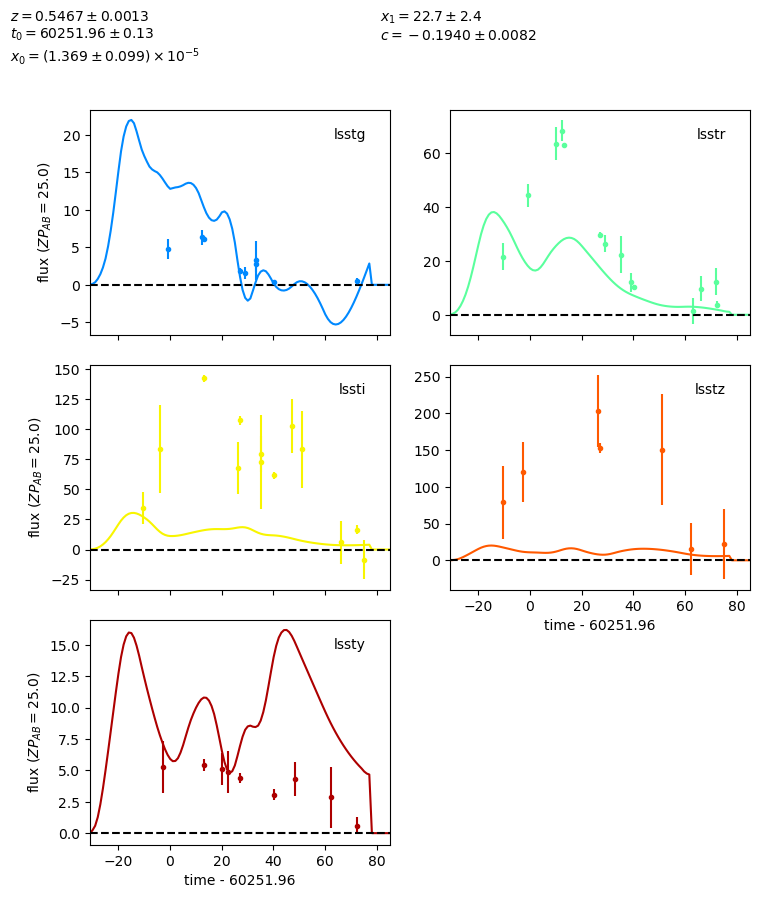

In [6]:
fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, pulls=False)
fig.savefig('SN_22047_real.jpg')

In [7]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 513
Number of degrees of freedom in fit: 47
chi^2 value at minimum: 6585.421703883287
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 5.46677340e-01  6.02519552e+04  1.36894202e-05  2.26689183e+01
 -1.94000242e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


Now, let's compare these results with those of doing the fitting manually.

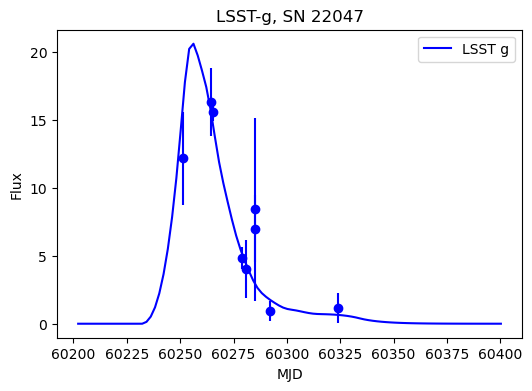

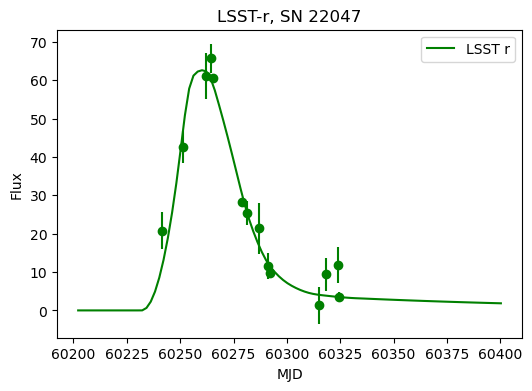

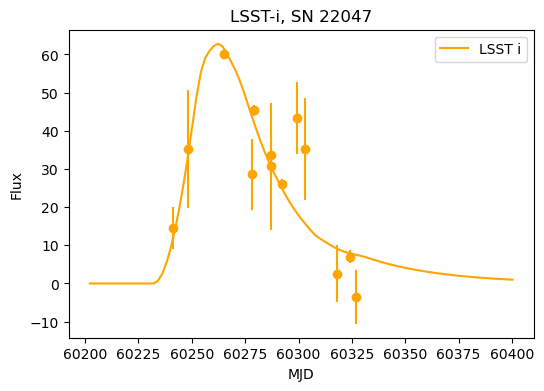

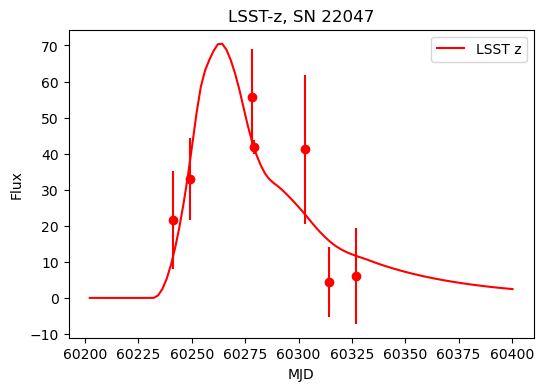

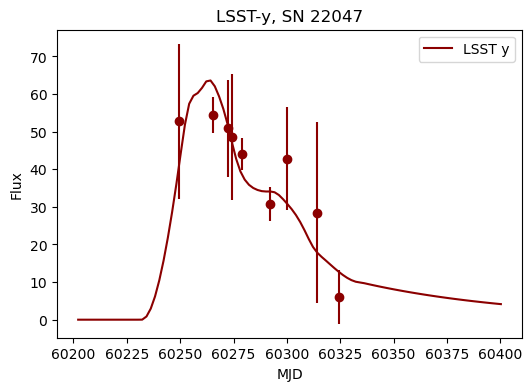

In [8]:
for band,color in zip(['g', 'r', 'i', 'z', 'y'], ['blue','green', 'orange', 'red', 'darkred']):
    fig = plt.figure(figsize=(6,4))
    mask_CID_data = (LCPLOT.CID.values==CID)&(LCPLOT['DATAFLAG'].values==1)&(LCPLOT['BAND'].values==band)
    mask_CID_fit = (LCPLOT.CID.values==CID)&(LCPLOT['DATAFLAG'].values==0)&(LCPLOT['BAND'].values==band)
    if len(LCPLOT.MJD.values[mask_CID_data])>0:
        plt.plot(LCPLOT.MJD.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit], '-', color=color, label="LSST "+band)
        #plt.fill_between(LCPLOT.MJD.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit]-LCPLOT.FLUXCAL_ERR.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit]+LCPLOT.FLUXCAL_ERR.values[mask_CID_fit], facecolor=color, alpha=0.2)
        plt.errorbar(LCPLOT.MJD.values[mask_CID_data], LCPLOT.FLUXCAL.values[mask_CID_data], LCPLOT.FLUXCAL_ERR.values[mask_CID_data], fmt='o', color=color)
    plt.title(f'LSST-{band}, SN 22047')
    plt.xlabel('MJD')    
    plt.ylabel('Flux')
    plt.legend()
    fig.savefig(f'SN_22047_SNANALC_LSST{band}.jpg')
    plt.show()

As we see from a quick glance at these light curves as compared to those from SNCosmo, they seem to fit the data better. I go further into the actual numerical analysis in the write-up.

### Real and simulated data

After seeing the somewhat poor results from SNCosmo with the "real" data alone, I thought it might be beneficial to see what would happen when you increase the number of inputted observations and whether or not this could resolve some of the issues with the light curves. I follow the exact same procedure as before except I make no constraints on the value of "DATAFLAG".

In [9]:
CID = 22047

times = []
band = []
flux = []
fluxerr = []
zp = []
zpsys = []

for i in range(len(LCPLOT.CID)):
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'g'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstg')
        zp.append(zp_vals[1])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'r'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstr')
        zp.append(zp_vals[2])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'i'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssti')
        zp.append(zp_vals[3])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'z'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstz')
        zp.append(zp_vals[4])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'y'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssty')
        zp.append(zp_vals[5])
        zpsys.append('ab')

data = Table({'time': times,
             'band': band,
             'flux': flux,
             'fluxerr': fluxerr,
             'zp': zp, 
             'zpsys': zpsys})

print(data)

   time    band   flux  fluxerr    zp    zpsys
--------- ----- ------- ------- -------- -----
60251.129 lsstg  12.172  3.4006 26.02534    ab
 60264.27 lsstg  16.313  2.5018 26.02534    ab
60265.254 lsstg  15.609 0.68599 26.02534    ab
60279.059 lsstg   4.847 0.80375 26.02534    ab
60281.051 lsstg  4.0283  2.1371 26.02534    ab
60285.141 lsstg  7.0127  2.4488 26.02534    ab
 60285.27 lsstg  8.4377  6.7389 26.02534    ab
60292.156 lsstg 0.92124 0.72529 26.02534    ab
60324.156 lsstg  1.1843  1.1074 26.02534    ab
60222.156 lsstg   0.636  1.0549 26.02534    ab
      ...   ...     ...     ...      ...   ...
60380.223 lssty  5.4002  2.1688     27.5    ab
60382.223 lssty  5.2583  2.1118     27.5    ab
60384.223 lssty  5.1201  2.0563     27.5    ab
60386.223 lssty  4.9856  2.0023     27.5    ab
60388.223 lssty  4.8546  1.9496     27.5    ab
60390.223 lssty   4.727  1.8984     27.5    ab
60392.223 lssty  4.6028  1.8485     27.5    ab
60394.223 lssty  4.4818  1.7999     27.5    ab
60396.223 lss

In [10]:
#create a model
model = sncosmo.Model(source='salt2-extended')

#run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  #parameters of model to vary
    bounds={'z':(0, 1)});

C:\Users\avacb\anaconda3\lib\site-packages\sncosmo\fitting.py:235: RuntimeWarning: invalid value encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]


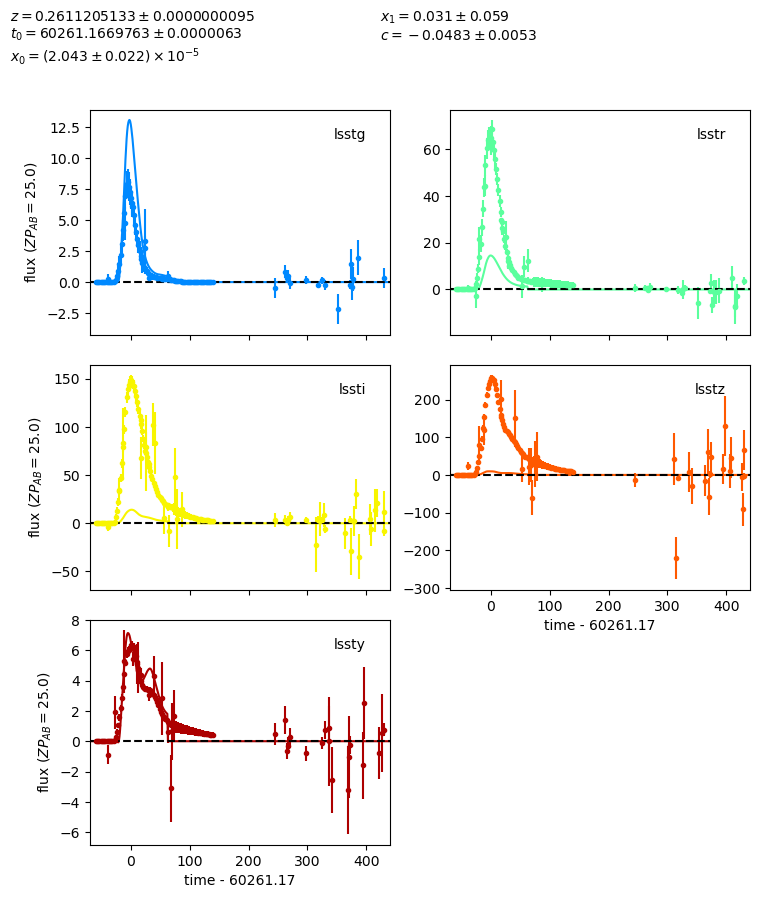

In [11]:
fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, pulls=False)
fig.savefig('SN_22047_sim.jpg')

In [12]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 1408
Number of degrees of freedom in fit: 665
chi^2 value at minimum: 47416.280559418934
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 2.61120513e-01  6.02611670e+04  2.04250483e-05  3.14059544e-02
 -4.83199951e-02]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


Now, just to make our analysis slightly more robust, I consider a second SN that also has well defined parameters from the SNANA simulation. The same procedure is followed.

### "Real" data only

In [13]:
'''using new file'''
LCPLOT = pd.read_csv('./SIMLIBwEUCLID.LCPLOT.TEXT', sep = ', ', engine='python', comment = '#') 

In [14]:
zp_vals = []

for i in range(len(FITRES.CID)):
    if FITRES.CID[i] == 22463:
        zp_vals.append(FITRES.HOST_SBMAG_u[i])
        zp_vals.append(FITRES.HOST_SBMAG_g[i])
        zp_vals.append(FITRES.HOST_SBMAG_r[i])
        zp_vals.append(FITRES.HOST_SBMAG_i[i])
        zp_vals.append(FITRES.HOST_SBMAG_z[i])
        zp_vals.append(FITRES.HOST_SBMAG_y[i])
print(zp_vals)

[27.5, 26.56197, 26.14118, 26.069, 26.50874, 27.5]


In [15]:
CID = 22463

times = []
band = []
flux = []
fluxerr = []
zp = []
zpsys = []

for i in range(len(LCPLOT.CID)):
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'g') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstg')
        zp.append(zp_vals[1])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'r') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstr')
        zp.append(zp_vals[2])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'i') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssti')
        zp.append(zp_vals[3])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'z') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstz')
        zp.append(zp_vals[4])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'y') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssty')
        zp.append(zp_vals[5])
        zpsys.append('ab')

data = Table({'time': times,
             'band': band,
             'flux': flux,
             'fluxerr': fluxerr,
             'zp': zp, 
             'zpsys': zpsys})

print(data)

   time    band  flux  fluxerr    zp    zpsys
--------- ----- ------ ------- -------- -----
62509.086 lsstg 40.234  3.3489 26.56197    ab
62532.078 lsstg 244.24  1.1282 26.56197    ab
62532.059 lsstr 352.48  1.1636 26.14118    ab
62517.078 lssti 277.54  8.5384   26.069    ab
62520.148 lssti 293.74  17.198   26.069    ab
62532.086 lssti 370.37  1.6854   26.069    ab
62517.113 lsstz 225.07  8.0239 26.50874    ab
62520.176 lsstz 279.43  22.734 26.50874    ab
62512.168 lssty 81.054  22.574     27.5    ab
62519.203 lssty 268.03   67.77     27.5    ab
62532.109 lssty 173.29  6.4368     27.5    ab


In [16]:
#create a model
model = sncosmo.Model(source='salt2-extended')

#run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  #parameters of model to vary
    bounds={'z':(0, 1)});

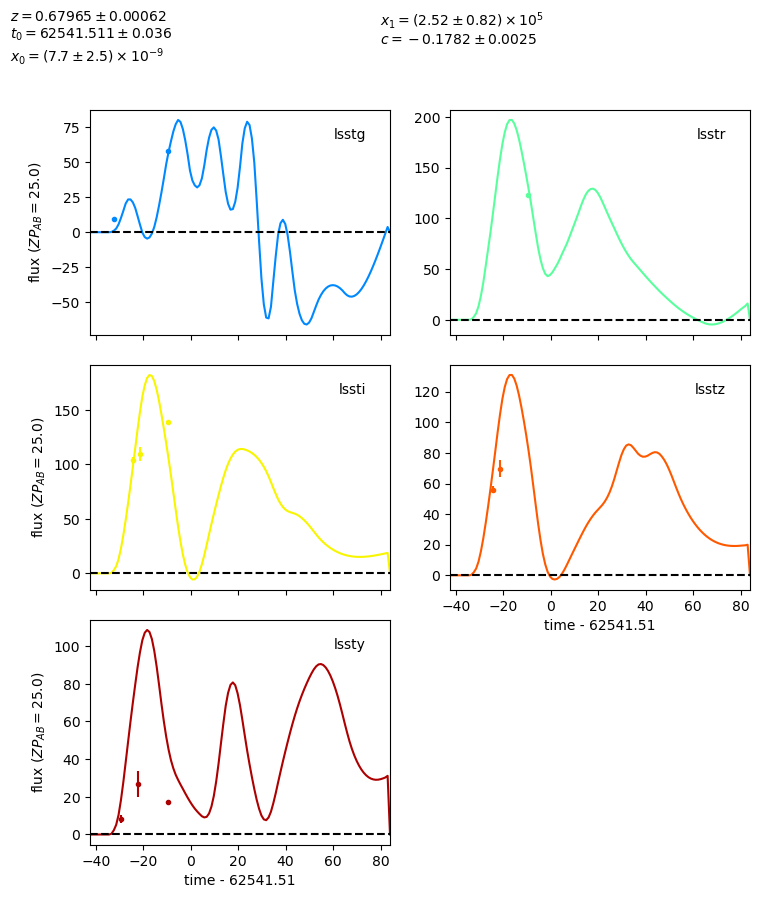

In [17]:
fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, pulls=False)
fig.savefig('SN_22463_real.jpg')

In [18]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 10012
Number of degrees of freedom in fit: 6
chi^2 value at minimum: 5217.68781841331
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 6.79651145e-01  6.25415106e+04  7.71808306e-09  2.52246429e+05
 -1.78157796e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


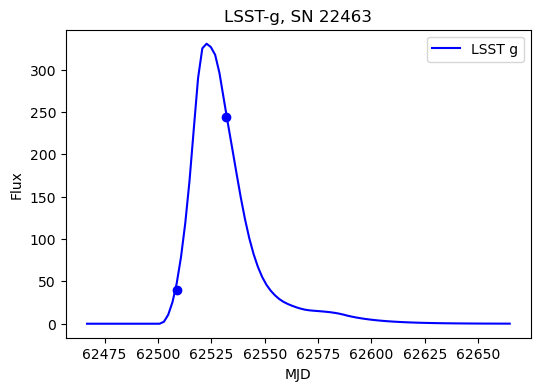

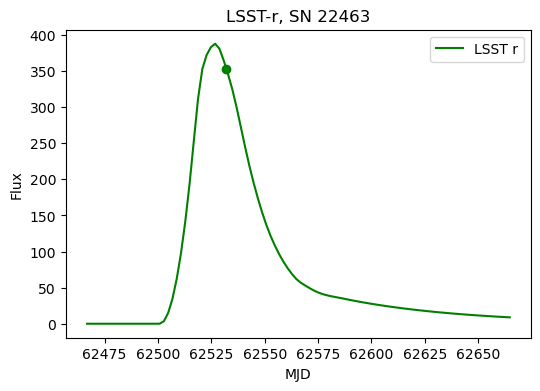

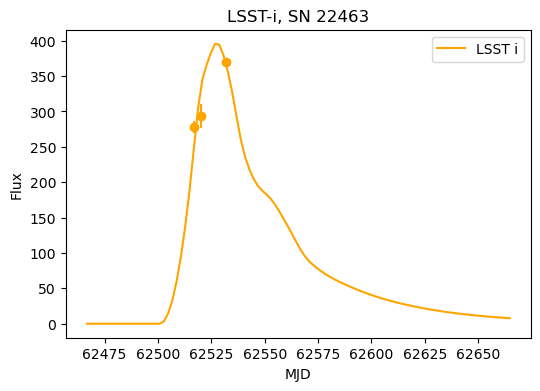

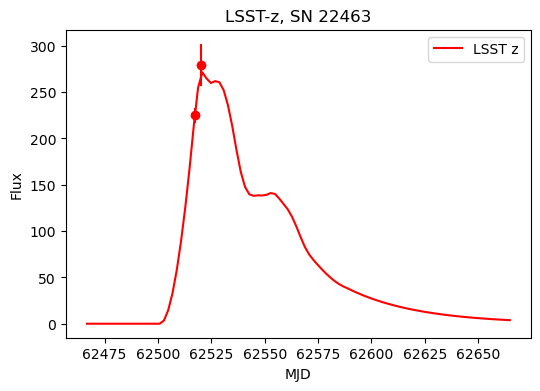

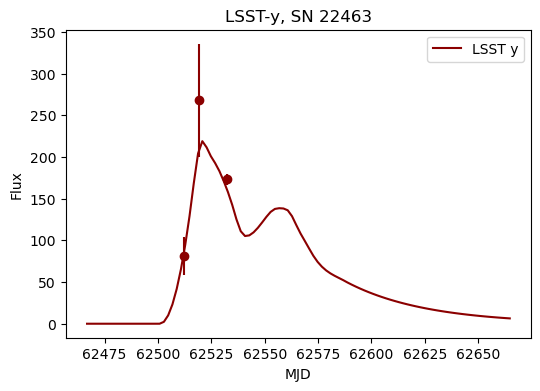

In [19]:
for band,color in zip(['g', 'r', 'i', 'z', 'y'], ['blue','green', 'orange', 'red', 'darkred']):
    fig = plt.figure(figsize=(6,4))
    mask_CID_data = (LCPLOT.CID.values==CID)&(LCPLOT['DATAFLAG'].values==1)&(LCPLOT['BAND'].values==band)
    mask_CID_fit = (LCPLOT.CID.values==CID)&(LCPLOT['DATAFLAG'].values==0)&(LCPLOT['BAND'].values==band)
    if len(LCPLOT.MJD.values[mask_CID_data])>0:
        plt.plot(LCPLOT.MJD.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit], '-', color=color, label="LSST "+band)
        #plt.fill_between(LCPLOT.MJD.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit]-LCPLOT.FLUXCAL_ERR.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit]+LCPLOT.FLUXCAL_ERR.values[mask_CID_fit], facecolor=color, alpha=0.2)
        plt.errorbar(LCPLOT.MJD.values[mask_CID_data], LCPLOT.FLUXCAL.values[mask_CID_data], LCPLOT.FLUXCAL_ERR.values[mask_CID_data], fmt='o', color=color)
    plt.title(f'LSST-{band}, SN 22463')
    plt.xlabel('MJD')    
    plt.ylabel('Flux')
    plt.legend()
    fig.savefig(f'SN_22463_SNANALC_LSST{band}.jpg')
    plt.show()

### Real and simulated data

In [20]:
CID = 22463

times = []
band = []
flux = []
fluxerr = []
zp = []
zpsys = []

for i in range(len(LCPLOT.CID)):
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'g'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstg')
        zp.append(zp_vals[1])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'r'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstr')
        zp.append(zp_vals[2])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'i'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssti')
        zp.append(zp_vals[3])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'z'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstz')
        zp.append(zp_vals[4])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'y'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssty')
        zp.append(zp_vals[5])
        zpsys.append('ab')

data = Table({'time': times,
             'band': band,
             'flux': flux,
             'fluxerr': fluxerr,
             'zp': zp, 
             'zpsys': zpsys})

print(data)

   time    band   flux   fluxerr    zp    zpsys
--------- ----- -------- ------- -------- -----
62509.086 lsstg   40.234  3.3489 26.56197    ab
62532.078 lsstg   244.24  1.1282 26.56197    ab
62411.277 lsstg  0.95524  1.1261 26.56197    ab
62415.277 lsstg -0.45391 0.79183 26.56197    ab
62449.211 lsstg  0.31037  0.7625 26.56197    ab
62480.211 lsstg   2.3922  1.3512 26.56197    ab
62501.133 lsstg  -6.1953  3.2929 26.56197    ab
62507.234 lsstg   21.897   5.046 26.56197    ab
62776.293 lsstg  0.27956   1.445 26.56197    ab
62796.238 lsstg   0.9747 0.88735 26.56197    ab
      ...   ...      ...     ...      ...   ...
62644.773 lssty   10.944  6.1337     27.5    ab
62646.773 lssty   10.371  5.8122     27.5    ab
62648.773 lssty   9.8269  5.5075     27.5    ab
62650.773 lssty   9.3117  5.2188     27.5    ab
62652.773 lssty   8.8236  4.9452     27.5    ab
62654.773 lssty    8.361   4.686     27.5    ab
62656.773 lssty   7.9227  4.4403     27.5    ab
62658.773 lssty   7.5074  4.2075     27.

In [21]:
#create a model
model = sncosmo.Model(source='salt2-extended')

#run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  #parameters of model to vary
    bounds={'z':(0, 1)});

C:\Users\avacb\anaconda3\lib\site-packages\sncosmo\fitting.py:235: RuntimeWarning: invalid value encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
C:\Users\avacb\anaconda3\lib\site-packages\sncosmo\models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
C:\Users\avacb\anaconda3\lib\site-packages\sncosmo\models.py:812: RuntimeWarning: invalid value encountered in multiply
  return (self._parameters[0] * (m0 + self._parameters[1] * m1) *
C:\Users\avacb\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


RuntimeError: result is NaN for [ 0.704839 62683 7.5384e+08 1724.47 -25668.8 ]

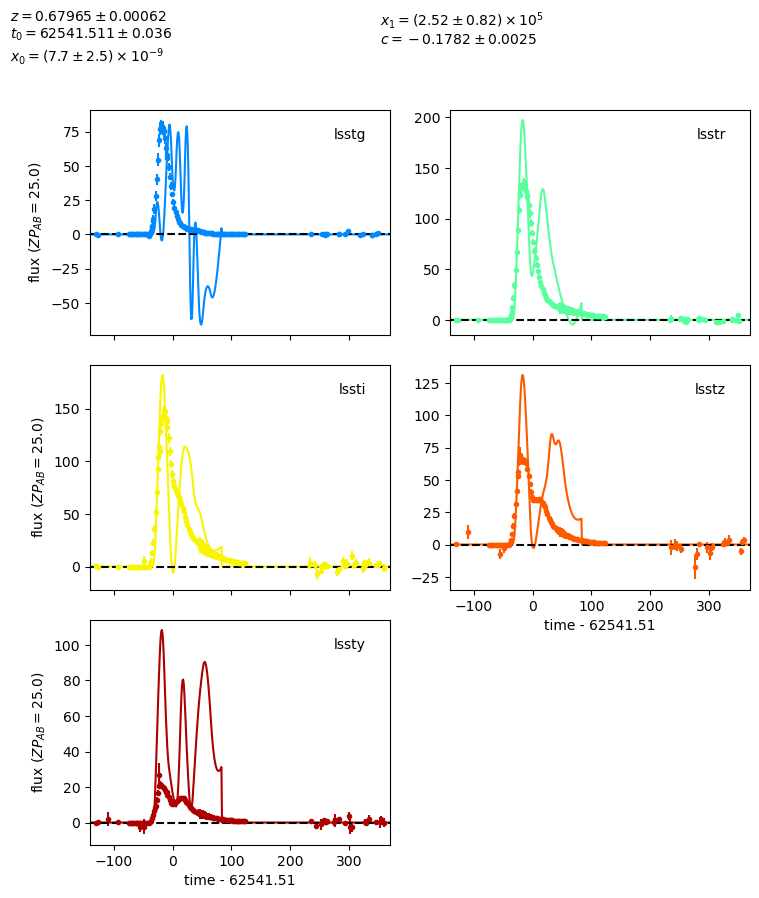

In [22]:
fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, pulls=False)
fig.savefig('SN_22463_sim.jpg')

In [23]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 10012
Number of degrees of freedom in fit: 6
chi^2 value at minimum: 5217.68781841331
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 6.79651145e-01  6.25415106e+04  7.71808306e-09  2.52246429e+05
 -1.78157796e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


### "Real" data only

In [24]:
zp_vals = []

for i in range(len(FITRES.CID)):
    if FITRES.CID[i] == 1744:
        zp_vals.append(FITRES.HOST_SBMAG_u[i])
        zp_vals.append(FITRES.HOST_SBMAG_g[i])
        zp_vals.append(FITRES.HOST_SBMAG_r[i])
        zp_vals.append(FITRES.HOST_SBMAG_i[i])
        zp_vals.append(FITRES.HOST_SBMAG_z[i])
        zp_vals.append(FITRES.HOST_SBMAG_y[i])
print(zp_vals)

[27.5, 24.04652, 22.88864, 22.47315, 22.17234, 27.5]


In [25]:
CID = 1744

times = []
band = []
flux = []
fluxerr = []
zp = []
zpsys = []

for i in range(len(LCPLOT.CID)):
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'g') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstg')
        zp.append(zp_vals[1])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'r') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstr')
        zp.append(zp_vals[2])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'i') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssti')
        zp.append(zp_vals[3])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'z') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstz')
        zp.append(zp_vals[4])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'y') & (LCPLOT.DATAFLAG[i] == 1):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssty')
        zp.append(zp_vals[5])
        zpsys.append('ab')

data = Table({'time': times,
             'band': band,
             'flux': flux,
             'fluxerr': fluxerr,
             'zp': zp, 
             'zpsys': zpsys})

print(data)

   time    band  flux  fluxerr    zp    zpsys
--------- ----- ------ ------- -------- -----
62122.289 lsstg 431.81  2.7443 24.04652    ab
62124.266 lsstg 376.17  2.3372 24.04652    ab
62130.297 lsstg 215.75  2.9618 24.04652    ab
62132.293 lsstg 183.35  2.0323 24.04652    ab
62151.227 lsstg 51.869   1.937 24.04652    ab
62153.203 lsstg 46.964  1.8963 24.04652    ab
62155.203 lsstg 49.696  2.7876 24.04652    ab
62157.199 lsstg 44.576  1.7203 24.04652    ab
62159.203 lsstg 44.106  1.6869 24.04652    ab
62122.281 lsstr 639.78  2.4582 22.88864    ab
      ...   ...    ...     ...      ...   ...
62159.195 lsstz 177.56   2.907 22.17234    ab
62122.312 lssty 351.47  7.0315     27.5    ab
62124.297 lssty 347.02  6.1047     27.5    ab
 62130.32 lssty 315.75  6.4448     27.5    ab
 62132.32 lssty 302.42  7.9683     27.5    ab
62136.324 lssty 325.74  19.083     27.5    ab
62151.246 lssty 250.47  6.3985     27.5    ab
62153.223 lssty 224.29  6.3735     27.5    ab
62155.223 lssty 191.82  10.227    

In [26]:
#create a model
model = sncosmo.Model(source='salt2-extended')

#run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  #parameters of model to vary
    bounds={'z':(0, 1)});

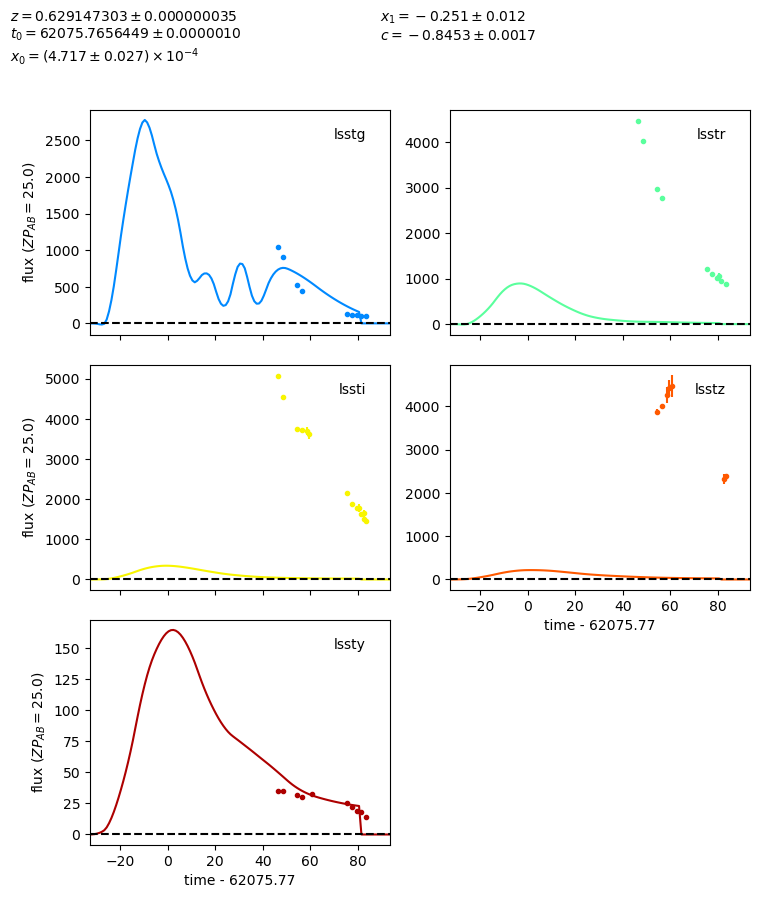

In [27]:
fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, pulls=False)
fig.savefig('SN_1744_real.jpg')

In [28]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 1768
Number of degrees of freedom in fit: 45
chi^2 value at minimum: 427848.9730359677
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 6.29147303e-01  6.20757656e+04  4.71699790e-04 -2.51327460e-01
 -8.45342955e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


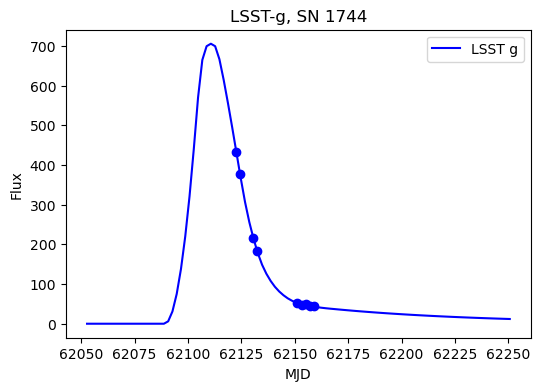

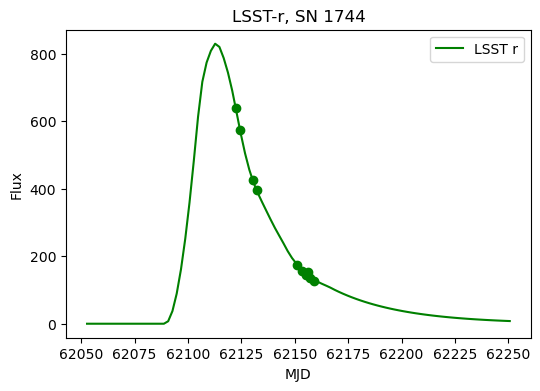

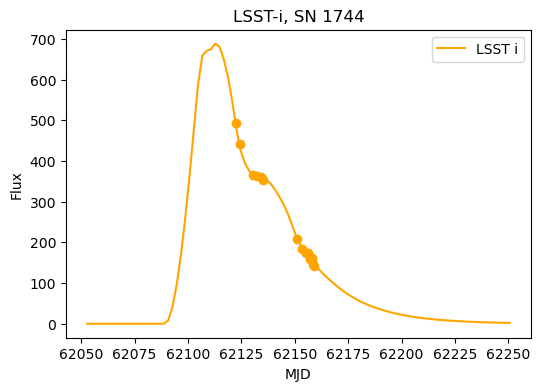

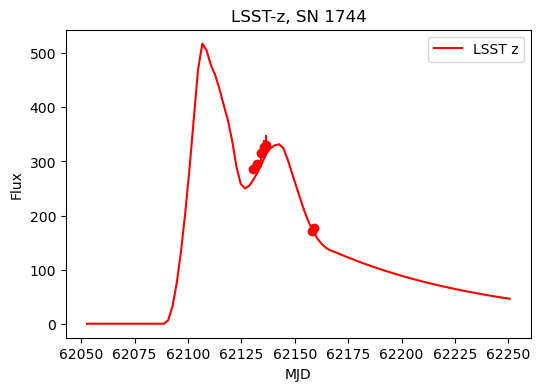

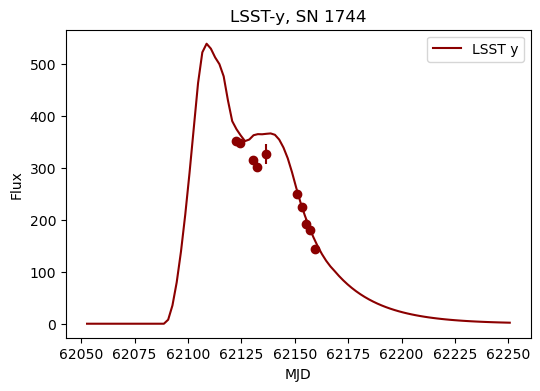

In [29]:
for band,color in zip(['g', 'r', 'i', 'z', 'y'], ['blue','green', 'orange', 'red', 'darkred']):
    fig = plt.figure(figsize=(6,4))
    mask_CID_data = (LCPLOT.CID.values==CID)&(LCPLOT['DATAFLAG'].values==1)&(LCPLOT['BAND'].values==band)
    mask_CID_fit = (LCPLOT.CID.values==CID)&(LCPLOT['DATAFLAG'].values==0)&(LCPLOT['BAND'].values==band)
    if len(LCPLOT.MJD.values[mask_CID_data])>0:
        plt.plot(LCPLOT.MJD.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit], '-', color=color, label="LSST "+band)
        #plt.fill_between(LCPLOT.MJD.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit]-LCPLOT.FLUXCAL_ERR.values[mask_CID_fit], LCPLOT.FLUXCAL.values[mask_CID_fit]+LCPLOT.FLUXCAL_ERR.values[mask_CID_fit], facecolor=color, alpha=0.2)
        plt.errorbar(LCPLOT.MJD.values[mask_CID_data], LCPLOT.FLUXCAL.values[mask_CID_data], LCPLOT.FLUXCAL_ERR.values[mask_CID_data], fmt='o', color=color)
    plt.title(f'LSST-{band}, SN 1744')
    plt.xlabel('MJD')    
    plt.ylabel('Flux')
    plt.legend()
    fig.savefig(f'SN_1744_SNANALC_LSST{band}.jpg')
    plt.show()

### Real and simulated data

In [30]:
CID = 1744

times = []
band = []
flux = []
fluxerr = []
zp = []
zpsys = []

for i in range(len(LCPLOT.CID)):
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'g'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstg')
        zp.append(zp_vals[1])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'r'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstr')
        zp.append(zp_vals[2])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'i'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssti')
        zp.append(zp_vals[3])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'z'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lsstz')
        zp.append(zp_vals[4])
        zpsys.append('ab')
    if (LCPLOT.CID[i] == CID) & (LCPLOT.BAND[i] == 'y'):
        flux.append(LCPLOT.FLUXCAL[i])
        fluxerr.append(LCPLOT.FLUXCAL_ERR[i])
        times.append(LCPLOT.MJD[i])
        band.append('lssty')
        zp.append(zp_vals[5])
        zpsys.append('ab')

data = Table({'time': times,
             'band': band,
             'flux': flux,
             'fluxerr': fluxerr,
             'zp': zp, 
             'zpsys': zpsys})

print(data)

   time    band  flux  fluxerr    zp    zpsys
--------- ----- ------ ------- -------- -----
62122.289 lsstg 431.81  2.7443 24.04652    ab
62124.266 lsstg 376.17  2.3372 24.04652    ab
62130.297 lsstg 215.75  2.9618 24.04652    ab
62132.293 lsstg 183.35  2.0323 24.04652    ab
62151.227 lsstg 51.869   1.937 24.04652    ab
62153.203 lsstg 46.964  1.8963 24.04652    ab
62155.203 lsstg 49.696  2.7876 24.04652    ab
62157.199 lsstg 44.576  1.7203 24.04652    ab
62159.203 lsstg 44.106  1.6869 24.04652    ab
62173.262 lsstg  37.09  6.7804 24.04652    ab
      ...   ...    ...     ...      ...   ...
62230.684 lssty 5.1523  2.5244     27.5    ab
62232.684 lssty 4.6805  2.2933     27.5    ab
62234.684 lssty 4.2519  2.0833     27.5    ab
62236.684 lssty 3.8625  1.8925     27.5    ab
62238.684 lssty 3.5088  1.7192     27.5    ab
62240.684 lssty 3.1875  1.5618     27.5    ab
62242.684 lssty 2.8956  1.4188     27.5    ab
62244.684 lssty 2.6305  1.2888     27.5    ab
62246.684 lssty 2.3896  1.1708    

In [31]:
#create a model
model = sncosmo.Model(source='salt2-extended')

#run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  #parameters of model to vary
    bounds={'z':(0, 1)});

C:\Users\avacb\anaconda3\lib\site-packages\sncosmo\fitting.py:235: RuntimeWarning: invalid value encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]


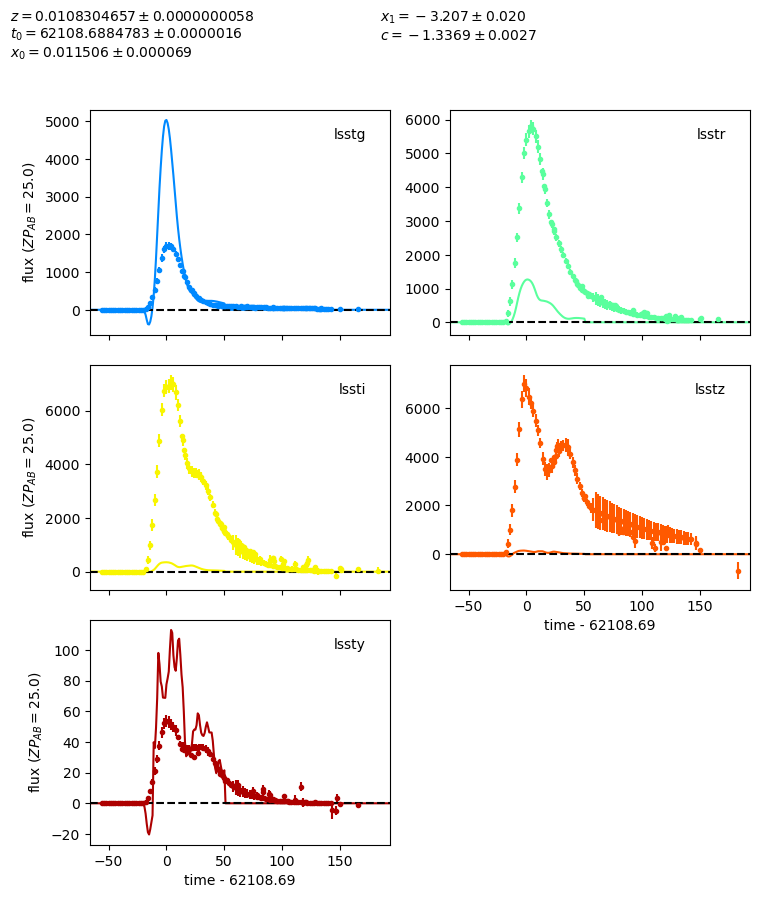

In [32]:
fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, pulls=False)
fig.savefig('SN_1744_sim.jpg')

In [33]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 1715
Number of degrees of freedom in fit: 667
chi^2 value at minimum: 420060.76327609736
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 1.08304657e-02  6.21086885e+04  1.15058498e-02 -3.20731888e+00
 -1.33692879e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])
